In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from rdkit.Chem import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganGenerator
morgan = GetMorganGenerator(radius=2)
fingerprinter = lambda smiles : np.stack([morgan.GetFingerprintAsNumPy(MolFromSmiles(smile)) for smile in smiles])

import torch
import torch.nn as nn
from models import RVMLP as VMLP

%load_ext autoreload
%autoreload 2

## Data

In [2]:
# Unimol Embeddings
train_X = np.load('../../data/transformed/train/unimol_cls_embeddings.npy')
validation_X = np.load('../../data/transformed/validation/unimol_cls_embeddings.npy')
test_X = np.load('../../data/transformed/test/unimol_cls_embeddings.npy')

In [3]:
train_Y = pd.read_csv('../../data/transformed/train/y.csv')
validation_Y = pd.read_csv('../../data/transformed/validation/y.csv')
test_Y = pd.read_csv('../../data/transformed/test/y.csv')

train_STD = pd.read_csv('../../data/transformed/train/std.csv')
validation_STD = pd.read_csv('../../data/transformed/validation/std.csv')
test_STD = pd.read_csv('../../data/transformed/test/std.csv')

properties = train_Y.columns

In [4]:
# Convert all to Tensors
train_X = torch.tensor(train_X, dtype=torch.float32).detach()
validation_X = torch.tensor(validation_X, dtype=torch.float32).detach()
test_X = torch.tensor(test_X, dtype=torch.float32).detach()

train_Y = torch.tensor(train_Y.to_numpy(), dtype=torch.float32).detach()
validation_Y = torch.tensor(validation_Y.to_numpy(), dtype=torch.float32).detach()
test_Y = torch.tensor(test_Y.to_numpy(), dtype=torch.float32).detach()

train_Var = torch.tensor(train_STD.to_numpy(), dtype=torch.float32).detach() ** 2
validation_Var = torch.tensor(validation_STD.to_numpy(), dtype=torch.float32).detach() ** 2
test_Var = torch.tensor(test_STD.to_numpy(), dtype=torch.float32).detach() ** 2

## MLP Model

## Train

In [5]:
vmlp = VMLP(in_features=512, depth=2, width=512, dropout=0.3)

vmlp.fit(
    train_X, train_Y, train_Var, 
    test_X, test_Y, 
)

0.053315818309783936

## Visualization

In [6]:
test_predictions = pd.DataFrame(vmlp(test_X)[0].detach())
test_predictions.columns = properties

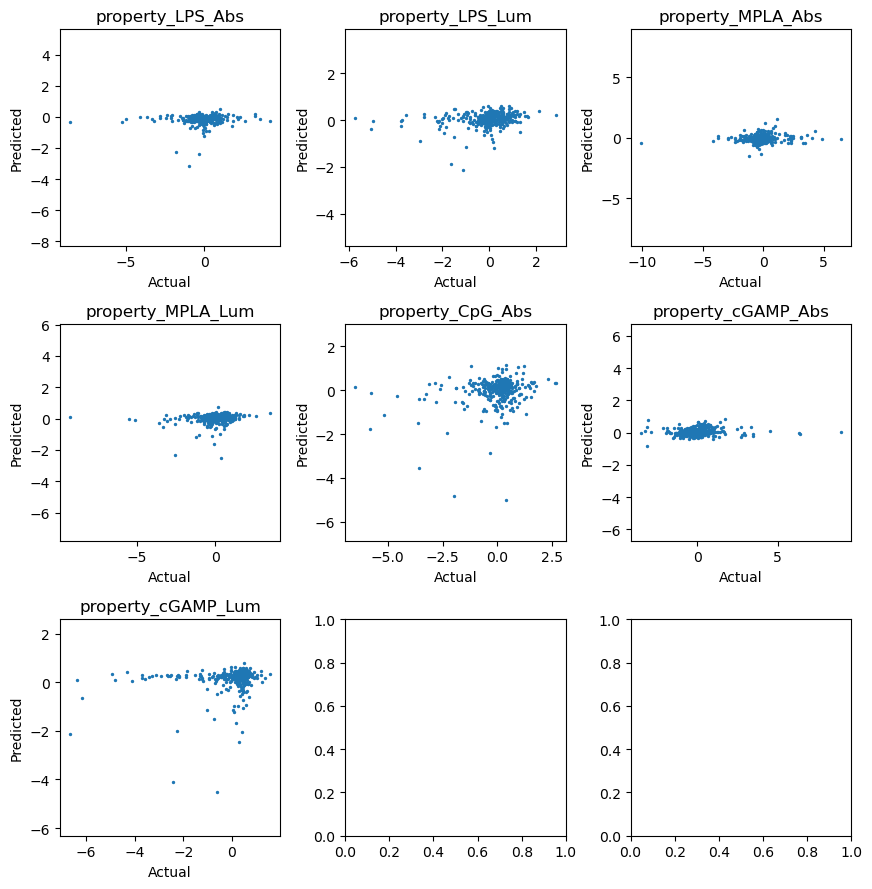

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.flatten()

for i, property_label in enumerate(properties):

    ax = axs[i]

    ax.scatter(test_Y[:, i], test_predictions.iloc[:, i], s=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(property_label)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()